![](img/563_banner.png)

# Lecture 4: More PCA, LSA, and NMF

UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar

## Lecture plan and learning outcomes

### Lecture plan 

- PCA recap and choosing $k$ (~20 mins)
- Other miscellaneous PCA stuff (~10 mins)
- Q&A and T/F questions (~5 mins)
- Break (~5 mins)
- TruncatedSVD or LSA (~20 mins)
- NMF (~10 mins)
- Q&A and T/F questions (~5 mins)
- Final comments and summary (~5 mins)

### Imports 

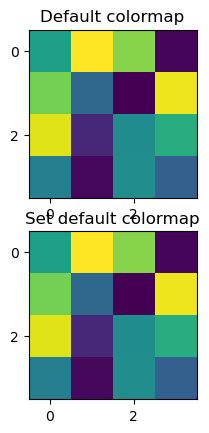

In [1]:
import os
import random
import sys
import time

import numpy as np

sys.path.append(os.path.join(os.path.abspath("."), "code"))
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from plotting_functions import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 16
# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

### Learning outcomes

From this lecture, students are expected to be able to:


- Explain how to write a training example as a linear combination of components, in the context of PCA;   
- Use `explained_variance_ratio_` of PCA to choose $k$ in the context of dimensionality reduction using PCA. 
- Explain the geometry of PCA for different values for $n$ and $d$. 
- Explain similarities and differences between K-Means and PCA. 
- State similarities and differences between `PCA`, `TruncatedSVD`, and `NMF`. 
- Interpret components givens given by PCA, Truncated SVD and NMF.  
- Recognize the scenarios for using `TruncatedSVD` and `NMF` and use them with `scikit-learn`. 

## Activity

- 2 volunteers
- Take pictures of the classroom from different angles (e.g., from each corner, from the center, from a low angle, and from above)
- Select a photo that best captures the classroom essence considering factors like visible objects, clarity, and perspective.
- Post your pictures on Slack.
- Why certain angles were better than other for capturing more information?

<br><br>

## 1. PCA recap

A commonly used dimensionality reduction technique. 

- PCA input
    - $X_{n \times d}$
    - the number of components $k$
- PCA output
    - $W_{k \times d}$ with $k$ principal components (also called "parts")
    - $Z_{n \times k}$ transformed data (also called "part weights")
- Usually $k << d$. 
- PCA is useful for dimensionality reduction, visualization, feature extraction etc.

**Important matrices involved in PCA**

PCA learns a $k$-dimensional subspace of the original $d$-dimensional space. Here are the main matrices involved in PCA.  

- $X \rightarrow$ Original data matrix
- $W \rightarrow$ Principal components
    - the best lower-dimensional hyper-plane found by the PCA algorithm
- $Z \rightarrow$ Transformed data with reduced dimensionality
    - the co-ordinates in the lower dimensional space  
- $X_{hat} \rightarrow$ Reconstructed data
    - reconstructions using $Z$ and $W$ in the original co-ordinate system

How can we use $W$ and $Z$? 

- Dimension reduction: compress data into limited number of components.
- Outlier detection: it might be an outlier if isn't a combination of usual components.
- Supervised learning: we could use $Z$ as our features.
- Visualization: if we have only 2 components, we can view data as a scatterplot.
- Interpretation: we can try and figure out what the components represent.

- PCA reduces the dimensionality by learning a $k$-dimensional subspace of the original $d$-dimensional space.
- When going from higher dimensional space to lower dimensional space, PCA still tries to capture the topology of the points in high dimensional space, making sure  that we are not losing some of the important properties of the data. 
- So Points which are nearby in high dimensions are still nearby in low dimension. 

- In PCA, we find a lower dimensional subspace so that the squared error of reconstruction, i.e., elements of $X$ and elements of $ZW$ is minimized. 
- The goal is to find the two best matrices such that when we multiply them we get a matrix that's closest to the data. 
- A common way to learn PCA is using singular value decomposition (SVD). 

**PCA examples**

- Let's look at examples of reducing dimensionality using PCA from 3 to 2 and from 3 to 1. 

In [2]:
n = 12
d = 3

x1 = np.linspace(0, 5, n) + np.random.randn(n) * 0.05
x2 = -x1 * 0.1 + np.random.randn(n) * 2
x3 = x1 * 0.7 + np.random.randn(n) * 3

X = np.concatenate((x1[:, None], x2[:, None], x3[:, None]), axis=1)
X = X - np.mean(X, axis=0)

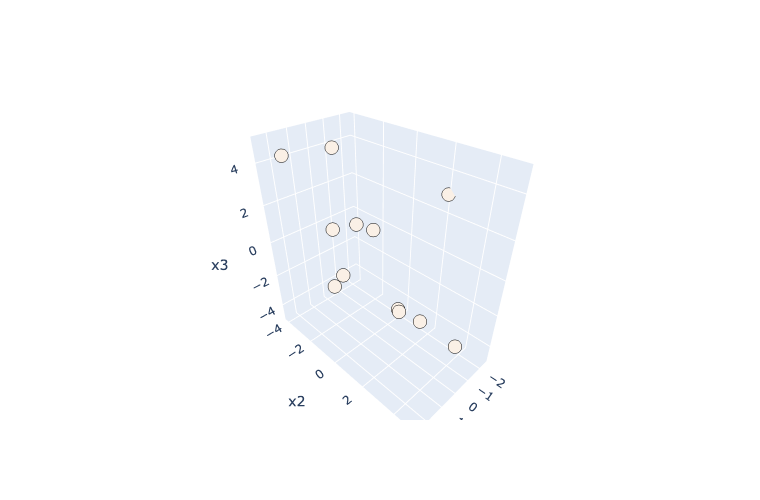

In [3]:
import plotly.express as px

plot_interactive_3d(X)

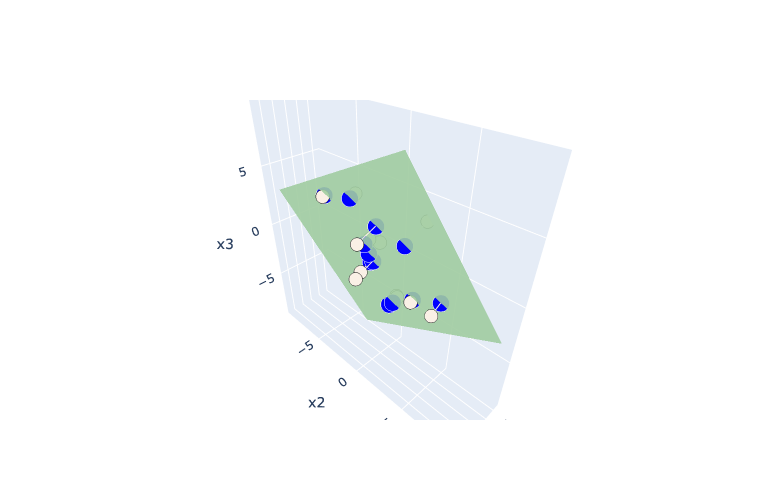

In [4]:
pca = PCA(n_components=2)
pca.fit(X)
plot_3d_2k(X, pca)

- The plane corresponds to $W$. 
- $Z_i$ are the co-ordinates of the $X_i$ projected onto the plane. 
- It gives us projected data in the new 2D coordinate system.
- $X_{hat}$ are reconstructions in the original 3D coordinate system.  

We can also plot the transformed `Z` values in two dimensions. 

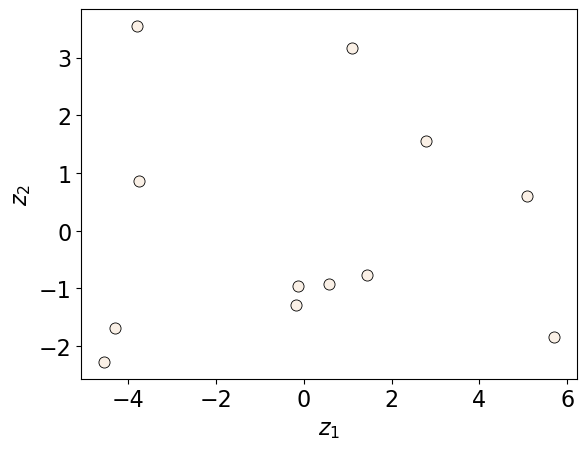

In [5]:
Z = pca.transform(X)
discrete_scatter(Z[:, 0], Z[:, 1])
plt.xlabel("$z_1$")
plt.ylabel("$z_2$");

How does this relate to maximum variance view of PCA? 
- To describe a two dimensional plane we need two basis vectors. 
- The first basis vector is in the direction of the maximum variance of the data and the second basis vector is in the second maximum variance in the data. 

### Moving to $d=3,k=1$
- Let's reduce dimensionality from 3 dimensions to 1 dimension. 
- Since $k = 1$, the $W$ matrix defines a line. 

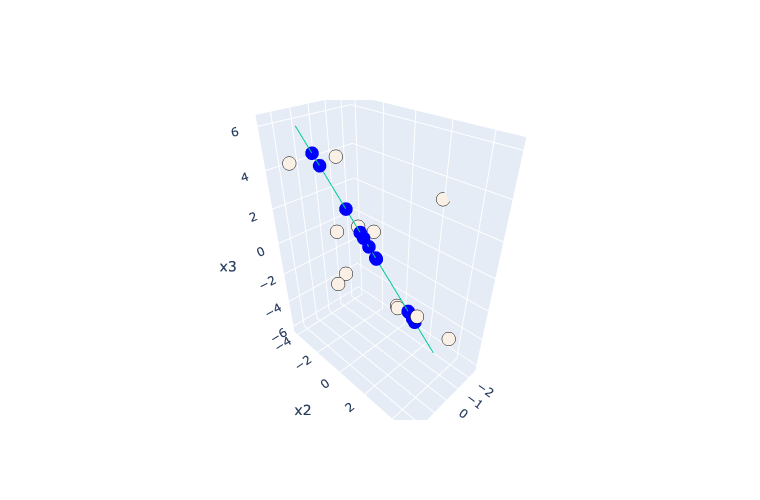

In [6]:
pca = PCA(n_components=1)
pca.fit(X)
plot_3d_1k(X, pca)

- The line corresponds to the $W$ vector. 
- $Z_i$ are the co-ordinates of the $X_i$ projected onto the line. 
- It gives us projected data in the new 1D coordinate system.
- $X_{hat}$ are reconstructions in the original 3D coordinate system.  

**Parts and part weights**

- In PCA terminology, the weight matrix $W$ is often called **parts** and their corresponding values in $Z$ are called **part weights**.
- We could represent an example as a linear combinations of components. 

**PCA reconstruction**

- We can get $\hat{X}_{n \times d}$ (reconstructed $X$) by matrix multiplication of $Z_{n \times k}$ and $W_{k \times d}$. 
$$\hat{X}_{n \times d} = Z_{n \times k}W_{k \times d} = \begin{bmatrix}
        z_{11} & \ldots & z_{1k}\\ 
        z_{21} & \ldots & z_{2k}\\ 
        & \vdots &\\        
        z_{i1} & \ldots & z_{ik}\\         
        & \vdots &\\
        z_{n1} & \ldots & z_{nk}
        \end{bmatrix}_{n \times k} \times 
        \begin{bmatrix}
            w_{11} & \ldots & w_{1d}\\ 
            w_{21} & \ldots & w_{2d}\\ 
            & \vdots &\\
            w_{k1} & \ldots & w_{kd}
            \end{bmatrix}_{k \times d}$$
- For instance, you can reconstruct an example $\hat{x_{i}}$ as follows:  

$$\hat{x_{i}} = \begin{bmatrix} z_{i1}w_{11} + z_{i2}w_{21} + \dots + z_{ik}w_{k1} \\ z_{i1}w_{12} + z_{i2}w_{22} + \dots + z_{ik}w_{k2}\\ \vdots\\ z_{i1}w_{1d} + z_{i2}w_{2d} + \dots + z_{ik}w_{kd}\end{bmatrix}_{d \times 1}$$

Rearranging the terms, we can see that $z_{i}$ values tell us how much each principal component to use to create this example. 
Each $z_i$ value act as weights in the linear combination of the principal components. A higher absolute value of $z_i$ means that the first principal component contributes more significantly to the reconstruction of the example. Conversely, a value close to zero would indicate a minimal contribution from the first principal component to the reconstruction of that example.

- Below, I'm writing the image of this funny cat from your lab as a linear combination of principal components ("parts"). 
- The coefficients in $Z$ tell us how much of each principal component to use to create this image.  
- In this image, components 0, 1, 3, 13 seem to be playing an important role.   

![](img/PCA-batcat-rep.png)

<br><br><br><br>

## 2. Choosing the number of components $k$

- Similar to K-Means there is no definitive answer.
- But we can use some strategies to help us out:
    - Look at the total explained variance by $k$ components.
    - Look at the reconstructions with $k$ components. 

- In PCA, principal components in $W$ are ordered by how much variance of the data they cover. 
- We can look at cumulative variance ratio (`explained_variance_ratio_` in `sklearn`) to select how many components we want. 
- When the data is human interpretable (e.g., images), you can also look at the reconstructions to help make this decision. 

- When we train a PCA model, it returns the amount of variance explained by each of the components. 
- In `sklearn`, we can access this using the `explained_variance_` attribute of the pca object.  
- And we can access the percentage of variance explained by each of the selected components with `explained_variance_ratio_` 
- Let's explore this on our toy pizza example. 

In [7]:
pizza_df = pd.read_csv("data/pizza.csv")
pizza_df.head()

brand     id   mois   prot    fat   ash  sodium  carb   cal
0  A     14069  27.82  21.43  44.87  5.11  1.77    0.77  4.93
1  A     14053  28.49  21.26  43.89  5.34  1.79    1.02  4.84
2  A     14025  28.35  19.99  45.78  5.08  1.63    0.80  4.95
3  A     14016  30.55  20.15  43.13  4.79  1.61    1.38  4.74
4  A     14005  30.49  21.28  41.65  4.82  1.64    1.76  4.67

In [8]:
X_pizza = pizza_df.drop(columns=["id", "brand"])
y_pizza = pizza_df["brand"]
X_pizza.head()

mois   prot    fat   ash  sodium  carb   cal
0  27.82  21.43  44.87  5.11  1.77    0.77  4.93
1  28.49  21.26  43.89  5.34  1.79    1.02  4.84
2  28.35  19.99  45.78  5.08  1.63    0.80  4.95
3  30.55  20.15  43.13  4.79  1.61    1.38  4.74
4  30.49  21.28  41.65  4.82  1.64    1.76  4.67

In [9]:
n_components = 2
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=n_components))
pipe_pca.fit(X_pizza)
W = pipe_pca.named_steps["pca"].components_

In [10]:
pipe_pca.named_steps["pca"].explained_variance_

array([4.18573434, 2.29811778])

In [11]:
pipe_pca.named_steps["pca"].explained_variance_ratio_

array([0.59596884, 0.3272082 ])

In [12]:
pipe_pca.named_steps["pca"].explained_variance_ratio_.sum()

0.9231770406002873

We are capturing 92.31% of the information using only two of these newly created features!!  

Let's look at how much "information" we can capture with different number of components. 

In [13]:
n_components = 7
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=n_components))
pipe_pca.fit(X_pizza)
W = pipe_pca.named_steps["pca"].components_

In [14]:
df = pd.DataFrame(
    data=np.cumsum(pipe_pca["pca"].explained_variance_ratio_),
    columns=["variance_explained (%)"],
    index=range(1, n_components + 1),
)
df.index.name = "n_components"

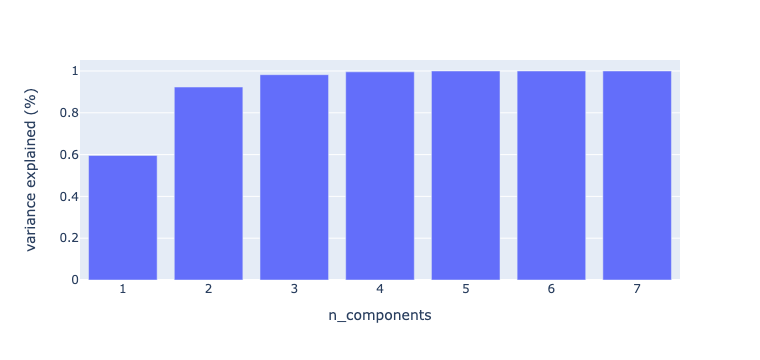

In [15]:
simple_bar_plot(
    x=df.index.tolist(),
    y=df["variance_explained (%)"],
    x_title="n_components",
    y_title="variance explained (%)",
)

In [16]:
pipe_pca.named_steps["pca"].explained_variance_

array([4.18573434e+00, 2.29811778e+00, 4.15948838e-01, 9.54925358e-02,
       2.77695834e-02, 3.38738483e-04, 9.55061572e-06])

Here is the percentage variance explained by the model. 

In [17]:
pipe_pca.named_steps["pca"].explained_variance_ratio_.sum()

0.9999999999999998

The sum of explained variance ratio covered by all components should be close to 1. 

Let's try it on a larger dataset. Let's bring back the human face images dataset, a small subset of [Human Faces dataset](https://www.kaggle.com/datasets/ashwingupta3012/human-faces) (available [here](https://ubcca-my.sharepoint.com/:u:/g/personal/varada_kolhatkar_ubc_ca/EYDqm7QJLfdGh1A0dyqh76kB6PH9ohca-lVrJGATrEh3CQ?e=msqcPM)).

In [18]:
import numpy as np
import pandas as pd
import random
import os
import torch
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms

from torchvision.models import vgg16
import matplotlib.pyplot as plt

In [19]:

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["image.cmap"] = "gray"

In [20]:
import torchvision

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [23]:
set_seed(seed=42)

In [24]:
import glob
IMAGE_SIZE = 200
def read_img_dataset(data_dir):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
            transforms.Grayscale(num_output_channels=1),            
            transforms.ToTensor(),
            transforms.Lambda(torch.flatten)
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [25]:
image_shape = (IMAGE_SIZE, IMAGE_SIZE)

In [26]:
def plot_sample_bw_imgs(inputs):
    fig, axes = plt.subplots(1, 5, figsize=(10, 8), subplot_kw={"xticks": (), "yticks": ()})
    for image, ax in zip(inputs, axes.ravel()):
        ax.imshow(image.reshape(image_shape))
    plt.show()    

In [27]:
data_dir = "data/people"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
faces_inputs, classes = read_img_dataset(data_dir)

In [28]:
X_faces = faces_inputs.numpy()
X_faces.shape

(367, 40000)

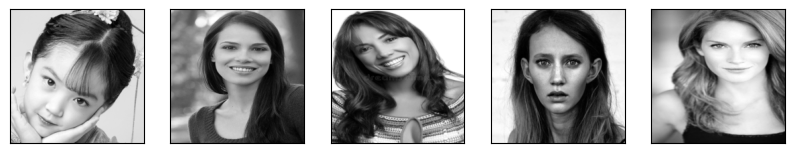

In [29]:
plot_sample_bw_imgs(X_faces[40:])

In [30]:
n_components = 200
pca = PCA(n_components=n_components, whiten=True, random_state=0)
pca.fit(X_faces)

PCA(n_components=200, random_state=0, whiten=True)

In [31]:
df = pd.DataFrame(
    data=np.cumsum(pca.explained_variance_ratio_),
    columns=["cummulative variance_explained (%)"],
    index=range(1, n_components + 1),
)
df.index.name = "n_components"

In [32]:
df

cummulative variance_explained (%)
n_components                                    
1             0.346940                          
2             0.445209                          
3             0.504753                          
4             0.551639                          
5             0.589833                          
...                ...                          
196           0.982018                          
197           0.982248                          
198           0.982475                          
199           0.982699                          
200           0.982920                          

[200 rows x 1 columns]

It doesn't make sense to plot a bar chart here, as we have so many components.

How about plotting number of components vs. explained variance?

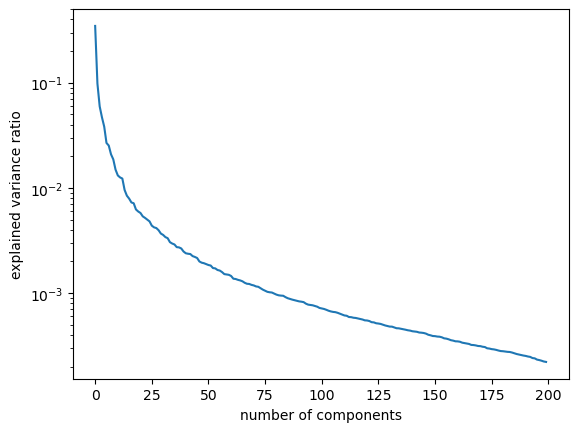

In [33]:
plt.semilogy(pca.explained_variance_ratio_)
plt.xlabel("number of components")
plt.ylabel("explained variance ratio");
plt.show()

A more useful plot is number of components vs. cumulative explained variance ratio.

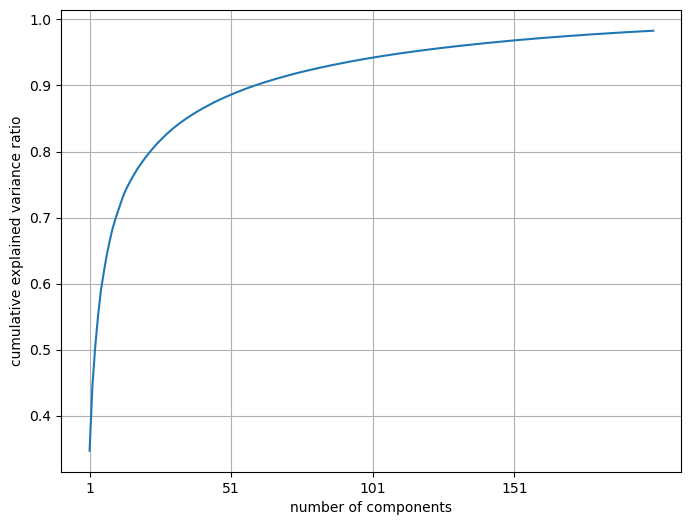

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 201), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1, 201, 50))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance ratio")
plt.grid();
plt.show()

Seems like we are capturing ~90% variance with only ~50 components! Remember that our dimensionality in the original dataset is 200 by 200 = 40000.

How do we choose the best value for the number of components? This will be application dependent.

<br><br>

## 3. Miscellaneous PCA-related things

### 3.1 PCA and multicollinearity 

- How do you think multicollinearity would affect PCA?

In [35]:
from scipy.stats import multivariate_normal, norm
X_mc = multivariate_normal.rvs(
    mean=[0, 0], cov=[[12, 11.5], [11.5, 12]], size=200, random_state=42
)

X_mc = np.column_stack((X_mc, np.sum(X_mc,axis=1)/2)) # Create a correlated feature which is summation of first 2 features/2. 

In [36]:
all((X_mc[:, 0] + X_mc[:, 1])/2 == X_mc[:, 2])

True

Do we really need the third dimension to describe the data? How would PCA handle this colinearity?  

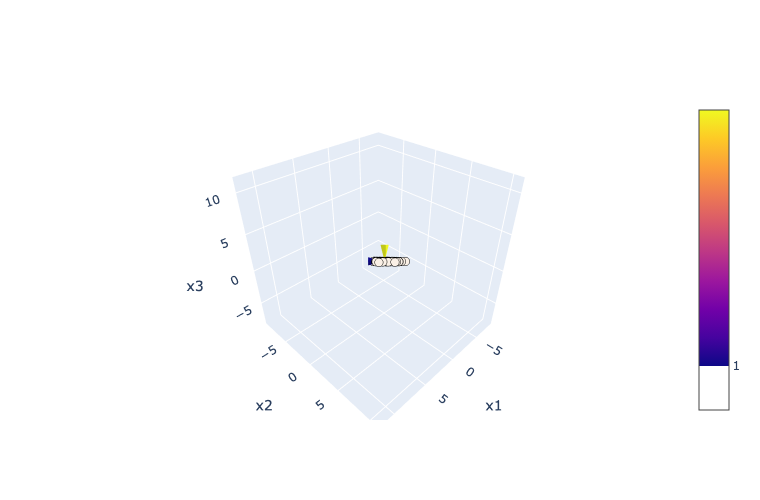

In [37]:
pca = PCA(n_components=3).fit(X_mc)
plot_multicollinearity_3d(X_mc, pca)

What's the variance associated with each component? 

In [38]:
pca.explained_variance_

array([3.23380503e+01, 4.65171412e-01, 3.63974669e-31])

The variance associated third component is very close to zero. 

In [39]:
np.allclose(pca.explained_variance_[2], np.zeros(1))

True

So when we train PCA on $X_{n \times d}$ with multicolinearity, 

- We will get $d$ orthogonal vectors.
- But the variance explained in some of the components would be zero. 

<br><br>

**(Optional) The relationship between the singular values and explained variance** 

In [40]:
singular_vals = pca.singular_values_
singular_vals

array([8.02201472e+01, 9.62128427e+00, 8.51063800e-15])

The relationship between the singular value $\sigma_i$ and the explained variance is 

$$\text{explained variance of } i_{th} \text{ component}  = \frac{\sigma^2_i}{N-1}$$

- $N \rightarrow$ the number of data points 

Let's get the explained variance by manipulating the singular values.

In our case, N=200. So the explained variance can be calculated as:   

In [41]:
(pca.singular_values_)**2/199

array([3.23380503e+01, 4.65171412e-01, 3.63974669e-31])

These values are exactly the same as explained variance. 

In [42]:
pca.explained_variance_

array([3.23380503e+01, 4.65171412e-01, 3.63974669e-31])

<br><br>

### 3.2 PCA and outliers
- PCA may or may not maintain outliers after applying transformation. 
- In the anomaly detection application, our assumption is that PCA is not able to maintain outliers and hence the reconstruction error for them would be higher compared to normal examples. 

> Robust PCA is more appropriate for anomaly detection task. We're not using it in lab because it's not implemented in `sklearn`. That said there are some external packages available. For example see [this implementation of robust PCA](https://github.com/dganguli/robust-pca). Also, `sklearn` might have it sometime soon. See [here](https://github.com/scikit-learn/scikit-learn/issues/5851). 


### 3.3 K-Means and PCA 

- You can think of PCA as generalization of K-Means. 
- In case of K-Means we learn a set of cluster centers and memorize these $K$ centers. 
- We represent the dataset in terms of those centers. 
- $W$ in K-Means has $K$ $d$-dimensional cluster centers. 
- $Z_i$ tells us which center the point belongs to. Each row of $Z$ has one element equal to one and the other are zero, indicating the cluster of that row.

In [43]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
pd.DataFrame(X, columns=["feat1", "feat2"])

feat1      feat2
0  5.691924 -9.476412 
1  1.707899  6.004352 
2  0.236210 -3.119100 
3  2.901595  5.421215 
4  5.859439 -8.381924 
5  6.047749 -10.305047
6 -2.007588 -7.247439 
7  1.454677 -6.583872 
8  1.536362  5.111215 
9  5.430704 -9.759561

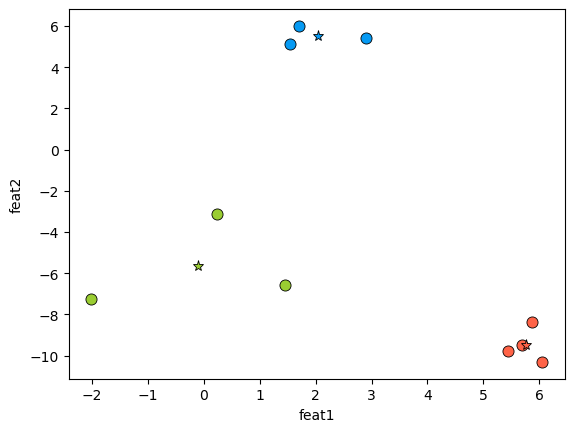

In [44]:
from sklearn.cluster import KMeans
n_clusters = 3
km = KMeans(n_clusters=n_clusters, n_init='auto')
km.fit(X)
centers=km.cluster_centers_
cluster_labels=km.labels_
discrete_scatter(X[:, 0], X[:, 1], cluster_labels, markers="o")
discrete_scatter(centers[:, 0], centers[:, 1], [0,1,2], markers="*")
plt.xlabel("feat1")
plt.ylabel("feat2")
plt.show()

You can think of cluster centers as the $W$ matrix of K-Means 

In [45]:
W_km = km.cluster_centers_
pd.DataFrame(W_km, columns=["feat1", "feat2"])

feat1     feat2
0  2.048619  5.512261
1 -0.105567 -5.650137
2  5.757454 -9.480736

You can think of the hard cluster assignments as part weights associated with components. 

In [46]:
Z_km = np.zeros((len(X), n_clusters), dtype="int32")
for i in range(len(X)):
    Z_km[i, cluster_labels[i]] = 1

col_names = ["center" + str(i) for i in range(n_clusters)]
pd.DataFrame(Z_km, columns=col_names)

center0  center1  center2
0  0        0        1      
1  1        0        0      
2  0        1        0      
3  1        0        0      
4  0        0        1      
5  0        0        1      
6  0        1        0      
7  0        1        0      
8  1        0        0      
9  0        0        1

- So we decompose $X$ as 
     $$X_{(n\times d)} \approx Z_{(n\times k)}W_{(k\times d)}$$
     
- You can think of reconstruction of each point as $\hat{X_i} = Z_iW$
- The reconstruction error would be high because we are capturing all data points in terms of just K cluster centers. 
- $Z$ in not continuous.

- PCA is a generalization that allows continuous values of $Z_i$s. 
- Does it make sense to `fit` a PCA model here with `n_components=3`? 

<br><br><br><br>

## ❓❓ Questions for you

### 4.1 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/NGJD**

- (A) Columns in $Z$ tell us about the amount of contribution of that principal component in the corresponding examples. 
- (B) A bigger value (in magnitude) of $Z_{i1}$ in the transformed data $Z$ means that component 1 does not play a big role in the decomposition of example $X_i$. 
- (C) In K-Means, each example is expressed with only one component or part whereas in PCA, each example is expressed with a linear combination of all components.   
- (D) If you have two collinear features in the data, PCA would only be able to find $d-1$ components because $d-1$ components would capture all the variance. 
- (E) In PCA, the components are statistically uncorrelated. 

```{admonition} V's Solutions!
:class: tip, dropdown
- A, C, E
```

<br><br><br><br>

## Break 

![](img/eva-coffee.png)

<br><br><br><br>

## 4. Varieties/extensions of PCA

### 4.1 PCA extensions

There are a number of PCA generalizations and extensions. Here are some examples. 

- [TuncatedSVD or Latent Semantic Analysis (LSA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [Non negative matrix factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
- [Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html) or [Mini-batch sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.MiniBatchSparsePCA.html)
- [KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)
- [IncrementalPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)
- Robust PCA (not implemented in sklearn yet)
- ...

In the next sections we'll see examples of `LSA` and NMF. 

### 4.2 Latent Semantic Analysis (LSA)

- Similar to PCA but does not center the data before calling SVD. 
- Useful for extracting semantically meaningful components of high dimensional sparse data.
- We can't easily use PCA in such cases because we can't subtract mean; if we do, it would force dense representation of the data and we won't even be able to store it. 

- Useful in the context of text data because BOW representation of text data is usually sparse and high dimensional. 
- This is also referred to as Latent Semantic Indexing (LSI) in the context of information retrieval.
- In `scikit-learn` the way to do this is using [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).  
    - Contrary to PCA, this algorithm does not center the data before calling `SVD`. 
    - So it's suitable for sparse, high-dimensional matrices (e.g., features extracted by `CountVectorizer`). 

- You can think of LSA as a tool for extracting semantic features or "topics" from a given set of documents. 
- It creates a dense representation of documents. 

$$X_{n \times d} \approx ZW$$


- Let's get an intuition for LSA with a toy example. 

In [47]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "raspberry",
    "pineapple juice",
    "mango fruit",
    "Vancouver",
    "Seattle",
    "Toronto",
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

mixed_sent = "Mango and pineapple are tropical. It's fun to eat fresh fruit in the city of Vancouver."    
wiki_dict["text"].append(mixed_sent)
wiki_dict["n_words"].append(len(word_tokenize(mixed_sent)))
wiki_dict["wiki query"].append('mixed')

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

wiki query  \
0  raspberry         
1  pineapple juice   
2  mango fruit       
3  Vancouver         
4  Seattle           
5  Toronto           
6  mixed             

                                                                                                                                                     text  \
0  The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.   
1  Pineapple juice is a juice made from pressing the natural liquid out from the pulp of the pineapple (a fruit from a tropical plant).                     
2  A mango is an edible stone fruit produced by the tropical tree Mangifera indica.                                                                         
3  Vancouver (  van-KOO-vər) is a major city in western Canada, located in the Lower Mainland region of British Columbia.                                   
4  Seattle (  see-AT-əl) is a seaport city on the West Coast of the United States.                                                                          
5  Toronto is the most populous city in Canada and the capital city of the Canadian province of Ontario.                                                    
6  Mango and pineapple are tropical. It's fun to eat fresh fruit in the city of Vancouver.                                                                  

   n_words  
0  30       
1  27       
2  15       
3  22       
4  17       
5  19       
6  19

Let's get BOW representation of the documents. 

In [48]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")
bow = cv.fit_transform(wiki_df["text"]).toarray()
bow_df = pd.DataFrame(bow, columns=cv.get_feature_names_out(), index=wiki_df["text"])
bow_df

british  \
text                                                                                                                                                              
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.  0         
Pineapple juice is a juice made from pressing the natural liquid out from the pulp of the pineapple (a fruit from a tropical plant).                    0         
A mango is an edible stone fruit produced by the tropical tree Mangifera indica.                                                                        0         
Vancouver (  van-KOO-vər) is a major city in western Canada, located in the Lower Mainland region of British Columbia.                                  1         
Seattle (  see-AT-əl) is a seaport city on the West Coast of the United States.                                                                         0         
Toronto is the most populous city in Canada and the capital city of the Canadian province of Ontario.                                                   0         
Mango and pineapple are tropical. It's fun to eat fresh fruit in the city of Vancouver.                                                                 0         

                                                                                                                                                        canada  \
text                                                                                                                                                             
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.  0        
Pineapple juice is a juice made from pressing the natural liquid out from the pulp of the pineapple (a fruit from a tropical plant).                    0        
A mango is an edible stone fruit produced by the tropical tree Mangifera indica.                                                                        0        
Vancouver (  van-KOO-vər) is a major city in western Canada, located in the Lower Mainland region of British Columbia.                                  1        
Seattle (  see-AT-əl) is a seaport city on the West Coast of the United States.                                                                         0        
Toronto is the most populous city in Canada and the capital city of the Canadian province of Ontario.                                                   1        
Mango and pineapple are tropical. It's fun to eat fresh fruit in the city of Vancouver.                                                                 0        

                                                                                                                                                        canadian  \
text                                                                                                                                                               
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.  0          
Pineapple juice is a juice made from pressing the natural liquid out from the pulp of the pineapple (a fruit from a tropical plant).                    0          
A mango is an edible stone fruit produced by the tropical tree Mangifera indica.                                                                        0          
Vancouver (  van-KOO-vər) is a major city in western Canada, located in the Lower Mainland region of British Columbia.                                  0          
Seattle (  see-AT-əl) is a seaport city on the West Coast of the United States.                                                                         0          
Toronto is the most populous city in Canada and the capital city of the Canad

- Each document is represented with 68 features, i.e., words. 
- Probably there is a set of features related to sports (e.g., _team, sport, ice, hockey, outdoor, played, skating_) and a set of features related to fruit (e.g., _fruit, juice, mango, tree, tropical_)? 

- Can we extract these **latent features**, which are there in the data but haven't manifested yet? 

In [49]:
lsa_pipe = make_pipeline(
    CountVectorizer(stop_words="english"), TruncatedSVD(n_components=2)
)

lsa_transformed = lsa_pipe.fit_transform(wiki_df["text"]);

In [50]:
pd.DataFrame(
    np.round(lsa_transformed, 4),
    columns=["latent topic 0", "latent topic 1"],
    index=wiki_df["text"],
)

latent topic 0  \
text                                                                                                                                                                     
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.  1.3750           
Pineapple juice is a juice made from pressing the natural liquid out from the pulp of the pineapple (a fruit from a tropical plant).                    2.9113           
A mango is an edible stone fruit produced by the tropical tree Mangifera indica.                                                                        1.3785           
Vancouver (  van-KOO-vər) is a major city in western Canada, located in the Lower Mainland region of British Columbia.                                  1.3517           
Seattle (  see-AT-əl) is a seaport city on the West Coast of the United States.                                                                         0.4704           
Toronto is the most populous city in Canada and the capital city of the Canadian province of Ontario.                                                   1.0467           
Mango and pineapple are tropical. It's fun to eat fresh fruit in the city of Vancouver.                                                                 2.0847           

                                                                                                                                                        latent topic 1  
text                                                                                                                                                                    
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus. -0.9334          
Pineapple juice is a juice made from pressing the natural liquid out from the pulp of the pineapple (a fruit from a tropical plant).                   -1.5782          
A mango is an edible stone fruit produced by the tropical tree Mangifera indica.                                                                       -0.5970          
Vancouver (  van-KOO-vər) is a major city in western Canada, located in the Lower Mainland region of British Columbia.                                  2.8688          
Seattle (  see-AT-əl) is a seaport city on the West Coast of the United States.                                                                         0.8225          
Toronto is the most populous city in Canada and the capital city of the Canadian province of Ontario.                                                   1.9484          
Mango and pineapple are tropical. It's fun to eat fresh fruit in the city of Vancouver.                                                                 0.1904

- Latent topic 0 seems to be dominant in the fruit-related documents. 
- Latent topic 1 seems to be dominant in city-related documents. 

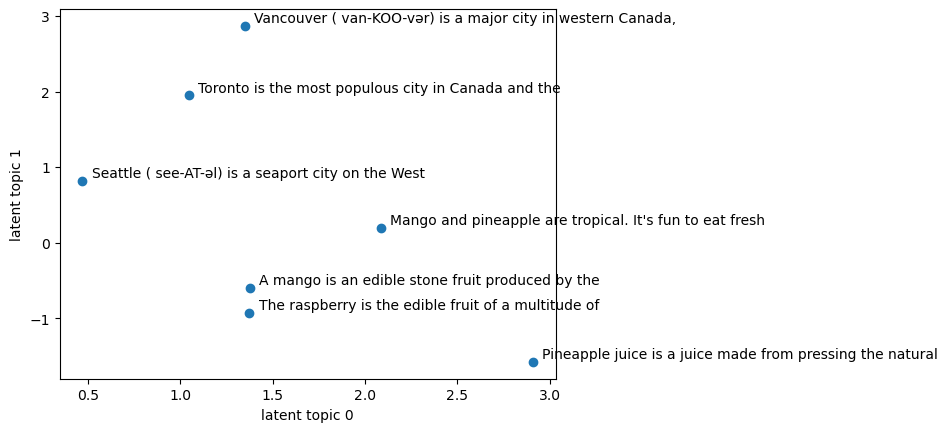

In [51]:
plt.scatter(lsa_transformed[:, 0], lsa_transformed[:, 1])
plt.xlabel("latent topic 0")
plt.ylabel("latent topic 1")
x = lsa_transformed[:, 0]
y = lsa_transformed[:, 1]
for i, txt in enumerate(wiki_df["text"]):
    plt.annotate(" ".join(txt.split()[:10]), (x[i] + 0.05, y[i] + 0.05))
plt.show()

Let's examine the components learned by LSA. 
- How much variance is covered by these two components? 

In [52]:
lsa_pipe.named_steps["truncatedsvd"].explained_variance_ratio_.sum()

0.31899149873313226

Good to know! 

- Our features are word counts. 
- Which features have higher weights in latent topic 0 vs. latent topic 1? 

What are the most important words for these latent topics?

In [53]:
sorting = np.argsort(lsa_pipe.named_steps["truncatedsvd"].components_, axis=1)[:, ::-1]

feature_names = np.array(
    lsa_pipe.named_steps["countvectorizer"].get_feature_names_out()
)
print_topics(
    topics=[0, 1], feature_names=feature_names, sorting=sorting, n_words=20
)

topic 0       topic 1       
--------      --------      
pineapple     city          
fruit         canada        
tropical      vancouver     
city          columbia      
juice         major         
plant         vər           
mango         van           
vancouver     western       
pressing      region        
liquid        koo           
pulp          located       
natural       lower         
edible        mainland      
canada        british       
fun           capital       
eat           populous      
fresh         province      
indica        ontario       
mangifera     toronto       
produced      canadian      




This makes sense!! 
- LSA has learned two useful "concepts" or latent features from 62 word count features: **cities** and **fruit**. 
- A nice thing is that this is completely unsupervised. 
- Instead of using BOW representation, we can create LSA representation of documents and pass it to supervised models.  

<br><br><br><br>

Let's try it out on a larger dataset. I'm using [Spotify Million Song Dataset](https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset) for this. 

In [54]:
df = pd.read_csv("data/spotify_millsongdata.csv")
sample_df = df.dropna()
sample_df.shape

(57650, 4)

In [55]:
sample_df.columns

Index(['artist', 'song', 'link', 'text'], dtype='object')

In [56]:
text_col = "text"

In [57]:
sample_df[text_col] = sample_df[text_col].apply(lambda x: x.replace('\r\n','')) 
sample_df[text_col] = sample_df[text_col].str.lower() 

A common transformation steps before calling LSA for text data is applying [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). 

- TF $\rightarrow$ term frequency 
- TF-IDF $\rightarrow$ term frequency times inverse document frequency

In [58]:
from nltk.corpus import stopwords
additional_stopwords = ['get', 'oh', 'baby', 'say', 'yeah', 'ya', 'na', 'got']
all_stopwords = list(set(stopwords.words('english')).union(additional_stopwords))

In [59]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler
n_components = 5
lsa_pipe = make_pipeline(
    CountVectorizer(stop_words=all_stopwords, ngram_range=(1, 2)),
    TfidfTransformer(),
    TruncatedSVD(n_components=n_components, n_iter=100, random_state=42),
)
lsa = lsa_pipe.fit_transform(sample_df[text_col]);

In [60]:
sorting = np.argsort(lsa_pipe.named_steps["truncatedsvd"].components_, axis=1)[:, ::-1]
feature_names = np.array(
    lsa_pipe.named_steps["countvectorizer"].get_feature_names_out()
)
print_topics(
    topics=np.arange(0, n_components),
    feature_names=feature_names,
    sorting=sorting,
    n_words=20,
)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
love          la            love          want          hey           
know          la la         love love     hey           hey hey       
like          sha la        need love     hey hey       christmas     
want          da            know love     let           like          
let           sha           heart         go            man           
time          da da         love need     know          girl          
one           fa la         need          let go        love          
go            fa            love like     wanna         little        
never         sing          love know     want want     love love     
see           la love       give love     gonna         gonna         
way           love la       true          girl          day           
come          la sha        true love     need          well          
chorus

- I don't see any coherent themes in the identified topics.
- Probably with more preprocessing and carefully chosen stopwords meaningful topics might emerge.   
- In 575, we'll revisit topic modeling with a Bayesian method called Latent Dirichlet Allocation (LDA). 

How much variance is covered by these components?

In [61]:
lsa_pipe.named_steps["truncatedsvd"].explained_variance_ratio_

array([0.00121934, 0.00284032, 0.00183745, 0.0011569 , 0.00107871])

- Truncated SVD does not find the directions of greatest variance when the data are not pre-centered. See [here](https://github.com/scikit-learn/scikit-learn/issues/3047). 

Instead of using bag-of-words representation in text classification, you can use LSA representation. 

- Similar performance with less overfitting with a lot less features (8592 features vs. 2000 features). 
- But it took a lot longer to extract these components. 

Another common way to preprocess counts data is using [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html), which scales each feature with its maximum absolute value.  

<br><br>

### 4.3 [Non-negative matrix factorization (NMF)](http://www.cs.columbia.edu/~blei/fogm/2018F/materials/LeeSeung1999.pdf)

- Published in Nature.
- High-level intro

- Another unsupervised learning algorithm to extract useful features. 
- Non-negative matrix factorization (NMF) uses a similar decomposition but with different constraints imposed on $Z$ and $W$. 
$$X_{(n\times d)} \approx Z_{(n\times k)}W_{(k\times d)}$$   
- Unlike PCA, the components are neither orthogonal to each other nor are they sorted by the variance explained by them. 
- The constraint in NMF is that both $Z$ and $W$ will be allowed to contain only non-negative values. 
- This means that it can only be applied to data where each feature is non-negative, as non-negative sum of non-negative components cannot become negative.

- The NMF "components" will only be adding things. 
- Once something is added it cannot be removed because we cannot subtract anything. 
- For example, in PCA you can have something like 
    - $X_i = 14W_0 - 9W_2$, a cancellation effect from subtraction. 
- In NMF, once you added $14W_0$ it cannot be cancelled out. 
- This usually leads to more interpretable models, as there are no cancellation effects due to different signs. 

**PCA Representation vs. NMF representation**
![](img/PCA-batcat-rep.png)

In NMF, 
- Everything is non-negative!
- No cancellation effects. 
![](img/nmf-batcat-ex.png)

- Helpful in scenarios where data is created with several independent sources. For example:  
    - audio track of multiple people speaking
    - music with many instruments
- The goal is to identify the original components that make up the combined data. 
- Relates to the notion of combining parts to create a whole. 

/Users/kvarada/miniconda3/envs/563/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1199: FutureWarning:

The default value of `n_components` will change from `None` to `'auto'` in 1.6. Set the value of `n_components` to `None` explicitly to suppress the warning.

/Users/kvarada/miniconda3/envs/563/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1199: FutureWarning:

The default value of `n_components` will change from `None` to `'auto'` in 1.6. Set the value of `n_components` to `None` explicitly to suppress the warning.

/Users/kvarada/miniconda3/envs/563/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



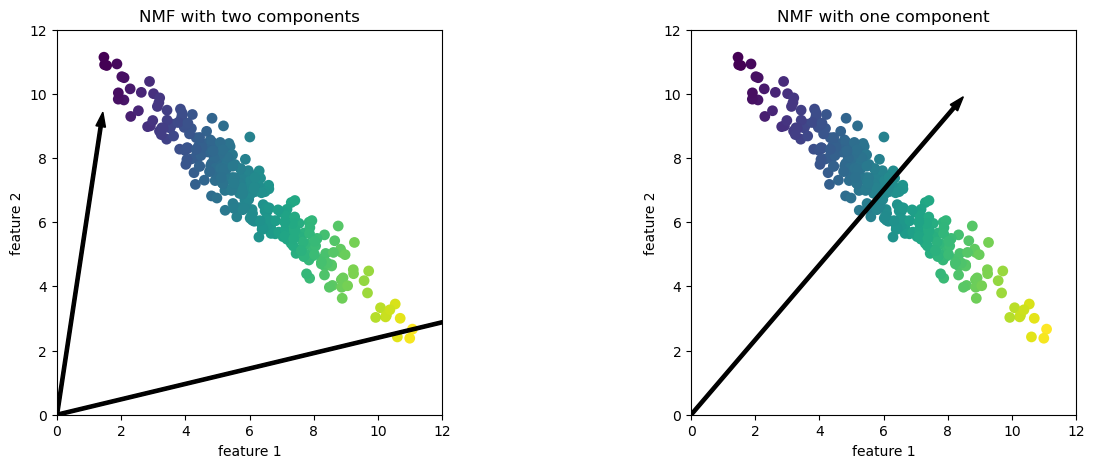

In [62]:
plot_nmf_illustration();

- In this case, if `n_components=2`, the components point towards the extremes of the data. 
- If we only have 1 component, according to NMF, point toward the mean, which best explains the data. 

**Effect of `n_components` on PCA vs. NMF**

- PCA is a **global algorithm** in the sense that the first principal component always points toward the direction of maximum variance and the second principal component toward the direction of second maximum variance and so on. 
- Changing the value for the number of components does not change this. 
- In contrast, in NMF, with different number of components we get entirely different set of components. 
- Components in NMF are also not ordered in any specific way and all components play an equal part.

Let's go back to our people faces dataset. 

In [63]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, init="random", random_state=123, max_iter=5000)
nmf.fit(X_faces)
Z_nmf = nmf.transform(X_faces)
W_nmf = nmf.components_

NMF is slower than PCA.  

Let's try to interpret the components given by NMF. 

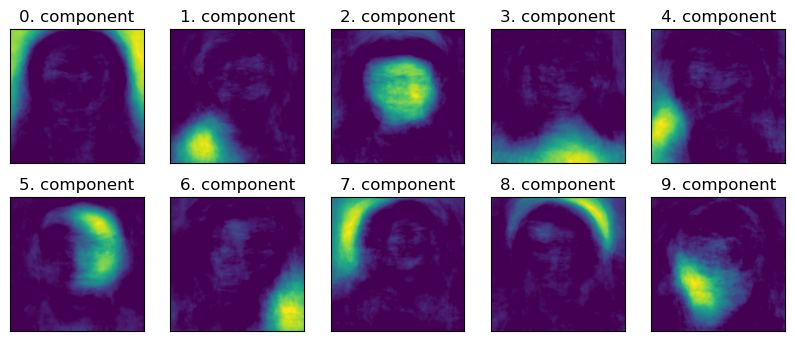

In [64]:
plot_components(W_nmf, image_shape)

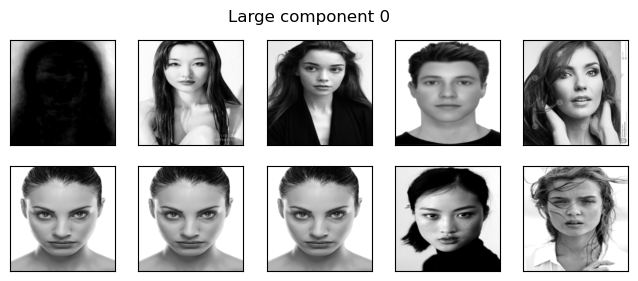

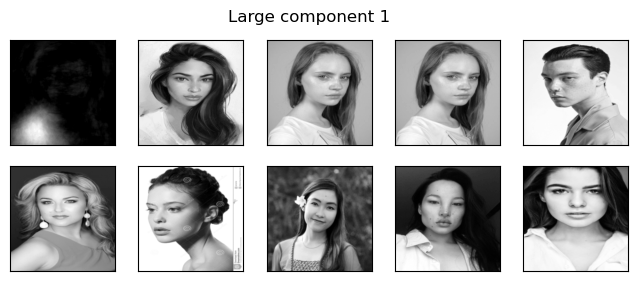

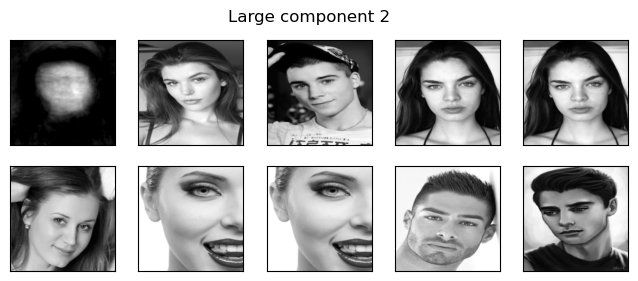

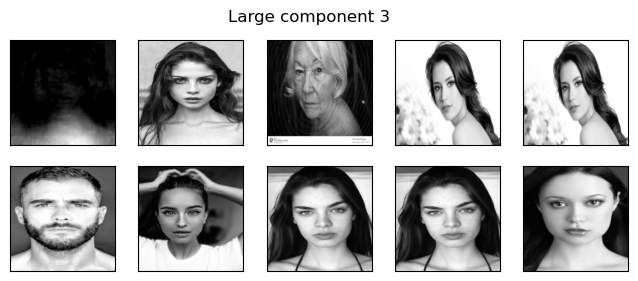

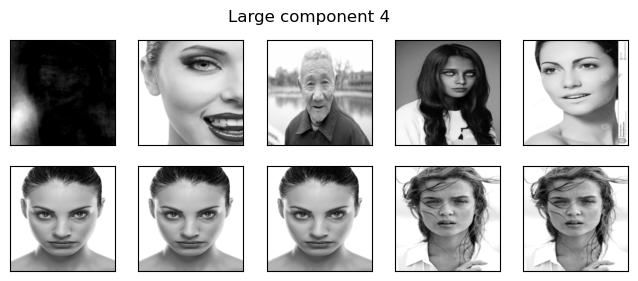

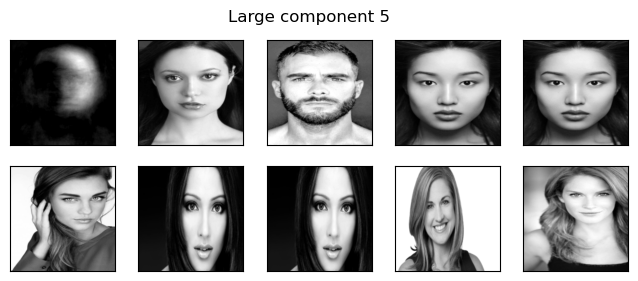

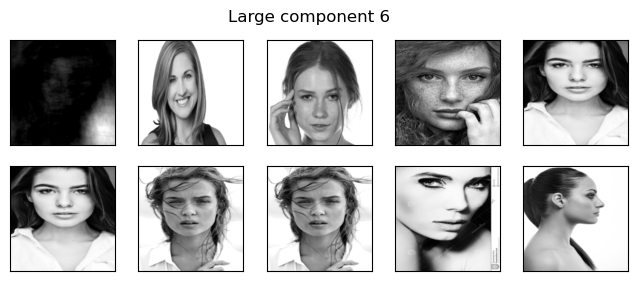

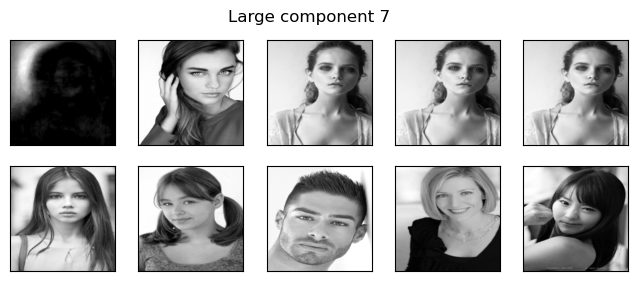

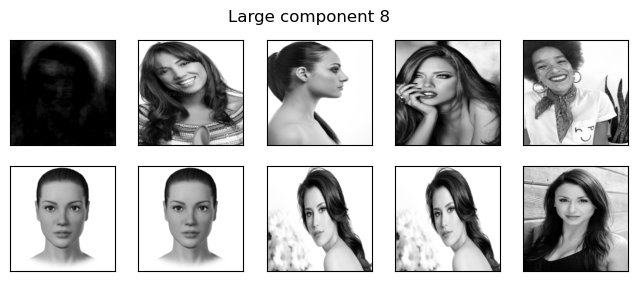

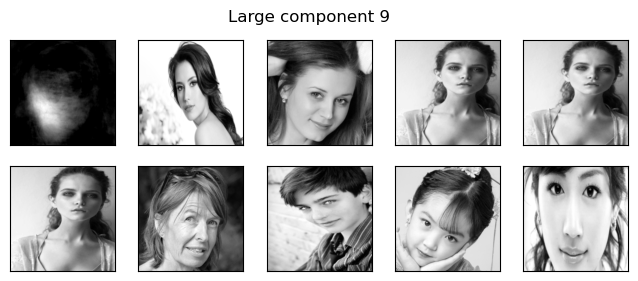

In [65]:
components=np.arange(0,10)
for compn in components: 
    plot_strong_comp_images(X_faces, Z_nmf, W_nmf, image_shape, compn=compn)

**Take-away points**

- For NMF everything is non-negative: the data, the components, and the transformed points. 
- Terms cannot cancel each other out which makes it more interpretable. 
- Unlike PCA, changing the number of components actually changes the directions of the other components. 


<br><br><br><br>

## 5. (Optional) Autoencoders

### Autoencoders 

<!-- <img src="img/autoencoder_digits.jpg" alt="" height="600" width="600">  -->
![](img/autoencoder_digits.jpg)

[Source](https://blog.keras.io/building-autoencoders-in-keras.html)

- Unsupervised learning technique for representation learning and dimensionality reduction.  
- It's a neural network architecture. 
- The idea is to create a "bottleneck" in the network so that the network is forced to learn compressed representation of the data. 


### Autoencoder architecture

![](img/autoencoder_wiki.png)
<!-- <img src="img/autoencoder_wiki.png" alt="" height="400" width="400">  -->

[Source](https://en.wikipedia.org/wiki/Autoencoder)

- The input layer is a vector representation of a data point. 
- It has two phases: encoding and decoding. 
- Encoding: The first layer transformed to a hidden layer. 
- Decoding: The last layer converts the lower dimensional representation back to the original dimensionality.

**What does it learn?**

- An autoencoder aims to minimize the distance of this reconstructed vector and the original vector. 
- And during this process, it creates good lower dimensional representations of the data. 


Let's look at a simple example of an autoencoder. Here is some synthetic data. 

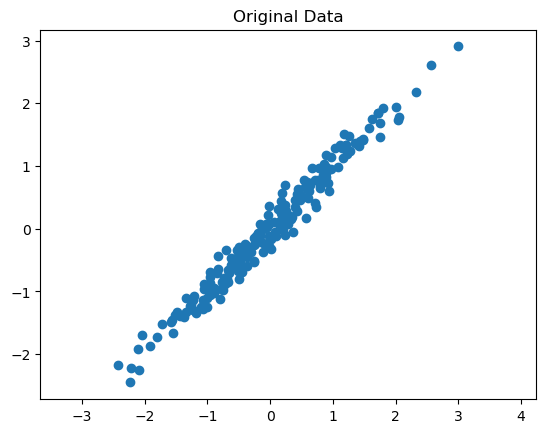

In [66]:
# Generate synthetic data
np.random.seed(0)
X = np.dot(np.random.rand(2, 2), np.random.randn(2, 200)).T
X = StandardScaler().fit_transform(X)  # Standardize data

plt.scatter(X[:, 0], X[:, 1])
plt.title("Original Data")
plt.axis('equal')
plt.show()

**PCA**
- Let's reduce the dimensionality from 2 to 1 with PCA 

In [67]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

# Project back to 2D
X_projected = pca.inverse_transform(X_pca)

In [68]:
!export MKL_VERBOSE=0

**Linear autoencoder**

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert numpy arrays to PyTorch tensors
X_torch = torch.tensor(X, dtype=torch.float32)

# Define the autoencoder
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super(LinearAutoencoder, self).__init__()
        self.encoder = nn.Linear(2, 1, bias=False)  # Encoder
        self.decoder = nn.Linear(1, 2, bias=False)  # Decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder
autoencoder = LinearAutoencoder()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

# Train the autoencoder
for epoch in range(500):
    # Forward pass
    output = autoencoder(X_torch)
    loss = criterion(output, X_torch)
    print('Loss: ', loss.item())
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Use the autoencoder to reconstruct the data
X_torch_encoded = autoencoder.encoder(X_torch).detach().numpy()
X_torch_decoded = autoencoder(X_torch).detach().numpy()

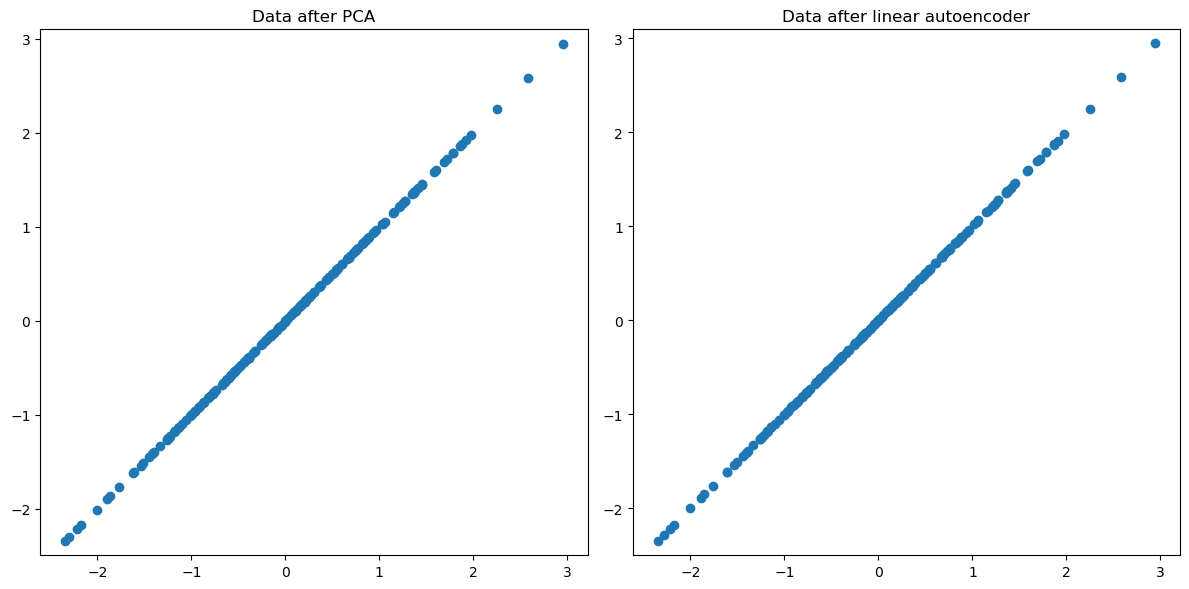

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot 1: Data after PCA
ax[0].scatter(X_projected[:, 0], X_projected[:, 1])
ax[0].set_title("Data after PCA")
ax[0].axis('equal')

# Plot 2: Data after Autoencoder (PyTorch)
ax[1].scatter(X_torch_decoded[:, 0], X_torch_decoded[:, 1])
ax[1].set_title("Data after linear autoencoder")
ax[1].axis('equal')

plt.tight_layout()
plt.show()

- When we use a single hidden layer without any non-linear activation functions, it essentially performs the same function as PCA.
  
- However, neural networks allow for greater creativity and flexibility. We can incorporate multiple layers, and not all of these layers need to be linear. For example, we can add convolutional layers among others. You'll explore this in one of the challenging questions in the lab. 

- Recall this picture of an autoencoder from 572. 
- Here we have more than one hidden layers. 
![](img/autoencoder.png)
<!-- <img src="img/autoencoder.png" alt="" height="500" width="500">  -->

**Non-linearity in autoencoders**

- PCA is a linear dimensionality reduction technique. 
- Autoencoders are non-linear because of non-linear activation functions. 
- In fact, if we construct the network without non-linear activation function at each layer, we would observe similar dimensionality reduction as that of PCA. 

<br><br><br><br>

## ❓❓ Questions for you


### 4.2 Select all of the following statements which are **True** (iClicker)

**iClicker cloud join link: https://join.iclicker.com/NGJD**

- (A) Suppose you are working with a dataset with 10 dimensions. You train `PCA` with `n_components=4` first. Then you train it with `n_components=1`. The absolute values in the first component vector are going to be exactly the same in both cases. 
- (B) Suppose you are working with a dataset with 10 dimensions. You train `NMF` with `n_components=4` first. Now if you train `NMF` with `n_components=1`.The absolute values in the first component vector are going to be exactly the same in both cases. 
- (C) Unlike bag-of-words representation, `TruncatedSVD` (LSA) gives a short and dense representation of documents. 
- (D) In LSA, the weight vectors in $W$ can be thought of as topics extracted from a set of documents. 
- (E) In LSA, the coefficients from the transformed data tell us the proportion of each topic in a given document. 

<br><br><br><br>

```{admonition} V's Solutions!
:class: tip, dropdown
- A, C, D, E
```

<br><br><br><br>

## 6. Final comments, summary, reflection

**Take-home message**

- PCA can be thought of as generalization of K-Means.
- In general, linear dimensionality reduction techniques represent each example as a linear combinations of components in $W$. 
- There are no definitive methods to decide the number of components. Two things which can help us out are 
    - looking at the explained variance in case of PCA 
    - looking at reconstructions 
- There are many variants and extensions of PCA.        
- `TruncatedSVD` or LSA is appropriate in the context of sparse text data, as it doesn't center the data. 
- In NMF everything is non-negative. 
- It is appropriate when you have non-negative data and interpretation is important for you.
- Also, it's useful when data is created as the addition of several independent sources (e.g., music with multiple sources) because NMF can identify the original components that make up the combined data. 

## Resources

- [Matrix decompositions & latent semantic indexing](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf)
- [NMF paper](http://www.cs.columbia.edu/~blei/fogm/2018F/materials/LeeSeung1999.pdf)